In [2]:
import sys
import warnings

warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

%matplotlib inline


from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)


In [4]:
from fbprophet import Prophet

In [5]:
dataset=pd.read_csv('https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/hour_online.csv',index_col=['Time'],parse_dates=['Time'])

In [6]:
plotly_df(dataset)

In [7]:
def moving_average(series, n):
    return np.average(series[-n:])


moving_average(
    dataset.Users, 24
)  # посмотрим на прогноз, построенный по последнему наблюдаемому дню (24 часа)

29858.333333333332

In [8]:
def plotMovingAverage(series, n, plot_bounds=False):

    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """

    rolling_mean = series.rolling(window=n).mean()

    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_bounds:
        rolling_std = series.rolling(window=n).std()
        upper_bound = rolling_mean + 1.96 * rolling_std
        lower_bound = rolling_mean - 1.96 * rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    # Деления соответствуют понедельникам что дает представление о недельной цикличности графика
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    # Отображать значение дат в формате yy-mm-dd
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d"))
    plt.xticks(rotation=45)

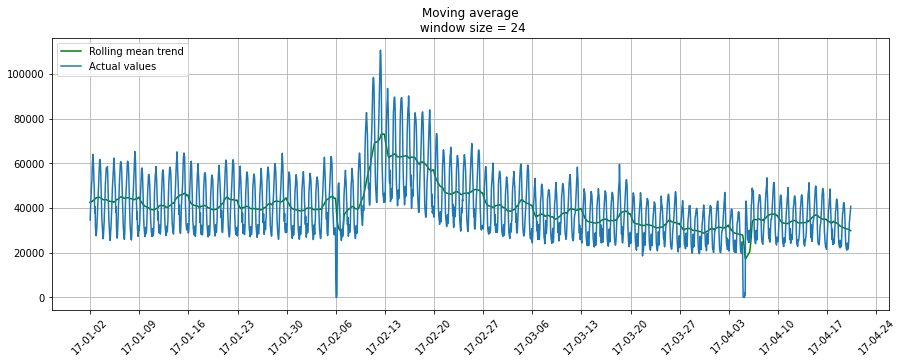

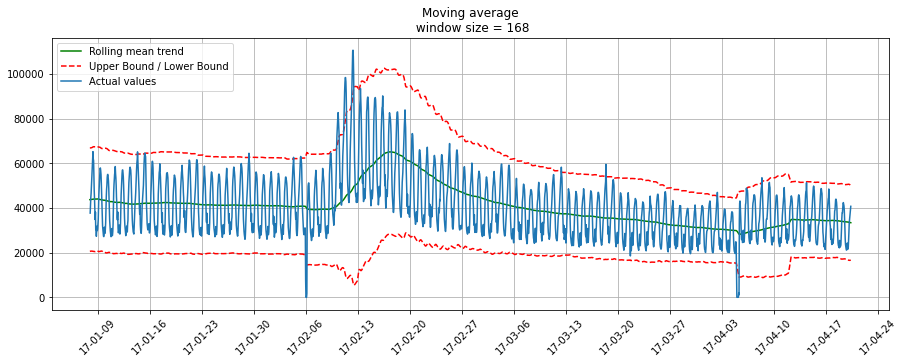

In [9]:
plotMovingAverage(dataset, 24)  # сглаживаем по дням
plotMovingAverage(dataset, 24 * 7, plot_bounds=True)  # сглаживаем по неделям

In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

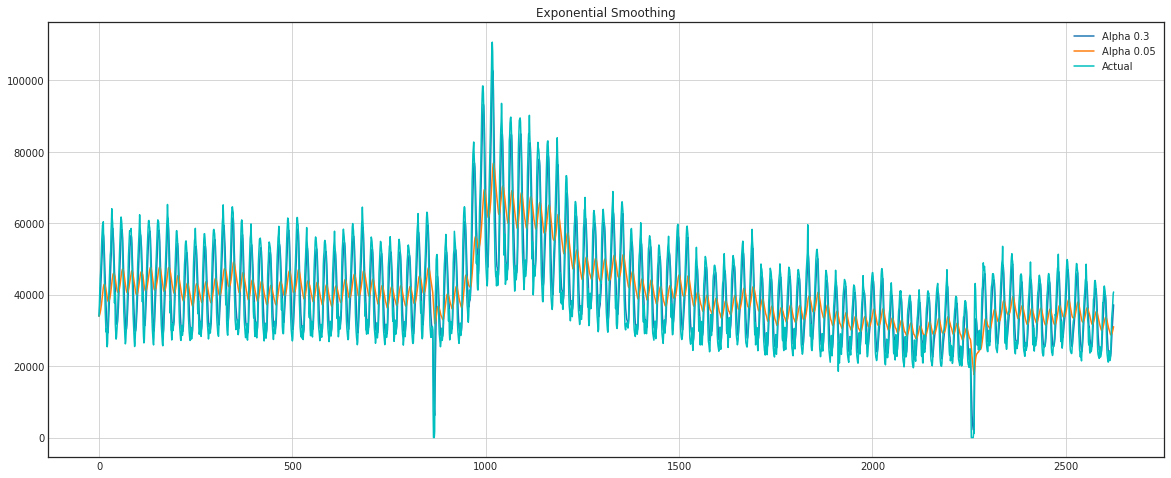

In [11]:
with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(
            exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha)
        )
    plt.plot(dataset.Users.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)

In [12]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

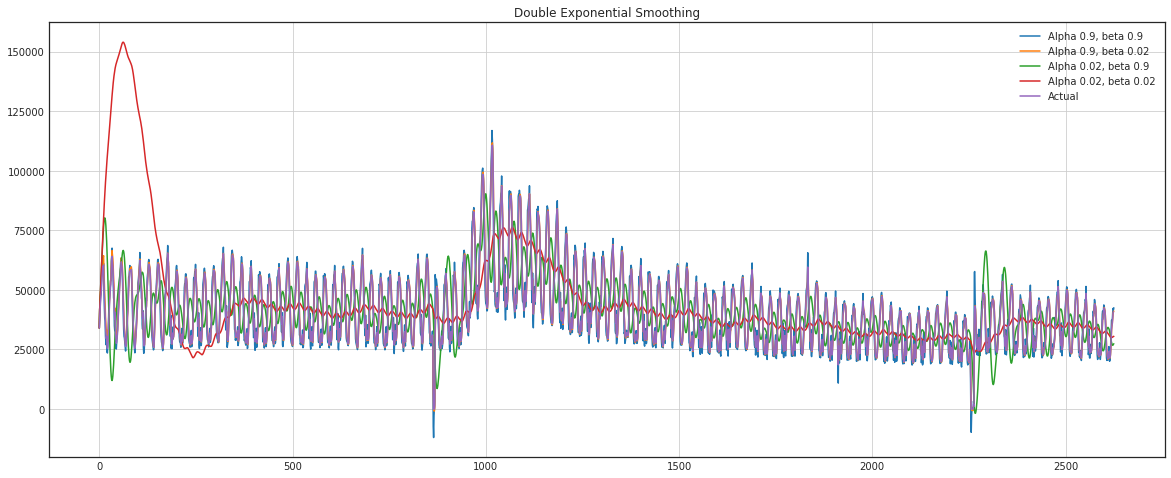

In [13]:
with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(
                double_exponential_smoothing(dataset.Users, alpha, beta),
                label="Alpha {}, beta {}".format(alpha, beta),
            )
    plt.plot(dataset.Users.values, label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [14]:
df=pd.read_csv('https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/wiki_machine_learning.csv',sep=' ')

In [15]:
df

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning
...,...,...,...,...,...,...,...
382,2016-01-16,1644,en,Machine_learning,8708,201601,Machine_learning
381,2016-01-17,1836,en,Machine_learning,8708,201601,Machine_learning
376,2016-01-18,2983,en,Machine_learning,8708,201601,Machine_learning
375,2016-01-19,3389,en,Machine_learning,8708,201601,Machine_learning


In [16]:
df.date = pd.to_datetime(df.date)

In [17]:
plotly_df(df.set_index("date")[["count"]])

In [60]:
import os

import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.1.0


In [72]:
df

,ds,y
81,2015-01-01,1414
80,2015-01-02,1920
79,2015-01-03,1338
78,2015-01-04,1404
77,2015-01-05,2264
...,...,...
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389


In [62]:
m=Prophet()

In [63]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

KeyError: "None of [Index(['date', 'count'], dtype='object')] are in the [columns]"

In [64]:
m.fit(train_df)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [65]:
train_df.tail()

y    1414
Name: 2015-01-01 00:00:00, dtype: int64

In [66]:
future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)

Exception: Model has not been fit.

In [67]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,2143.907754,2000.376414,2897.629681,2143.907754,2143.907754,284.023020,284.023020,284.023020,284.023020,284.023020,284.023020,0.0,0.0,0.0,2427.930773
1,2015-01-02,2146.583090,1734.830137,2621.445233,2146.583090,2146.583090,14.499169,14.499169,14.499169,14.499169,14.499169,14.499169,0.0,0.0,0.0,2161.082259
2,2015-01-03,2149.258425,872.587893,1748.580481,2149.258425,2149.258425,-855.162664,-855.162664,-855.162664,-855.162664,-855.162664,-855.162664,0.0,0.0,0.0,1294.095762
3,2015-01-04,2151.933761,994.438511,1843.628734,2151.933761,2151.933761,-714.091684,-714.091684,-714.091684,-714.091684,-714.091684,-714.091684,0.0,0.0,0.0,1437.842077
4,2015-01-05,2154.609097,2006.480255,2910.964886,2154.609097,2154.609097,288.945681,288.945681,288.945681,288.945681,288.945681,288.945681,0.0,0.0,0.0,2443.554778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2016-01-16,2963.838812,1657.448206,2557.783594,2946.514641,2980.856335,-855.162664,-855.162664,-855.162664,-855.162664,-855.162664,-855.162664,0.0,0.0,0.0,2108.676148
380,2016-01-17,2969.072853,1827.799617,2712.052025,2950.822920,2987.336046,-714.091684,-714.091684,-714.091684,-714.091684,-714.091684,-714.091684,0.0,0.0,0.0,2254.981169
381,2016-01-18,2974.306894,2816.269417,3723.760050,2954.547089,2993.666282,288.945681,288.945681,288.945681,288.945681,288.945681,288.945681,0.0,0.0,0.0,3263.252575
382,2016-01-19,2979.540935,3073.772623,3948.000988,2958.319526,3000.254890,548.913965,548.913965,548.913965,548.913965,548.913965,548.913965,0.0,0.0,0.0,3528.454899


In [68]:
cmp_df = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
    df.set_index("ds")
)
import numpy as np

cmp_df["e"] = cmp_df["y"] - cmp_df["yhat"]
cmp_df["p"] = 100 * cmp_df["e"] / cmp_df["y"]
np.mean(abs(cmp_df[-predictions:]["p"])), np.mean(abs(cmp_df[-predictions:]["e"]))

(33.90939671404633, 587.2644313986249)

In [69]:
cmp_df

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2015-01-01,2427.930773,2000.376414,2897.629681,1414,-1013.930773,-71.706561
2015-01-02,2161.082259,1734.830137,2621.445233,1920,-241.082259,-12.556368
2015-01-03,1294.095762,872.587893,1748.580481,1338,43.904238,3.281333
2015-01-04,1437.842077,994.438511,1843.628734,1404,-33.842077,-2.410404
2015-01-05,2443.554778,2006.480255,2910.964886,2264,-179.554778,-7.930865
...,...,...,...,...,...,...
2016-01-16,2108.676148,1657.448206,2557.783594,1644,-464.676148,-28.264973
2016-01-17,2254.981169,1827.799617,2712.052025,1836,-418.981169,-22.820325
2016-01-18,3263.252575,2816.269417,3723.760050,2983,-280.252575,-9.394991


In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

In [87]:
test = sm.tsa.adfuller(df.squeeze())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.2997371711587173
p-value:  0.014890227037347863
Critical values:  {'1%': -3.4482453822848496, '5%': -2.8694261442901396, '10%': -2.5709711770439507}
единичных корней нет, ряд стационарен


In [54]:
train_df=train_df.set_index(')

In [86]:
train_df=pd.Series(df.squeeze())

In [78]:
df=df.set_index('ds')

In [85]:
df.squeeze()

ds
2015-01-01    1414
2015-01-02    1920
2015-01-03    1338
2015-01-04    1404
2015-01-05    2264
              ... 
2016-01-16    1644
2016-01-17    1836
2016-01-18    2983
2016-01-19    3389
2016-01-20    3559
Name: y, Length: 384, dtype: int64

In [90]:
mod = sm.tsa.statespace.SARIMAX(df.squeeze(), trend='c', order=(1,2,1))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  384
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -3019.576
Date:                Mon, 02 Aug 2021   AIC                           6047.151
Time:                        14:27:44   BIC                           6062.933
Sample:                             0   HQIC                          6053.412
                                - 384                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0051      0.319     -0.016      0.987      -0.631       0.621
ar.L1          0.0448      0.040      1.108      0.268      -0.034       0.124
ma.L1         -1.0000      0.058    -17.387      0.0

In [ ]:
6045
6047